<a href="https://colab.research.google.com/github/aadipatodia/Movie_Recommendation_DAA_Project/blob/main/DAA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup and Data Download

This code block prepares the environment by installing the necessary library (`wget`) and importing all required Python libraries (`pandas`, `matplotlib.pyplot`, `seaborn`, `wget`, `os`). It then proceeds to download the MovieLens 100k dataset from a specified URL. The dataset is a zip file, which is then unzipped into a local folder named `ml-100k`. An `os.path.exists` check is included to prevent re-downloading the dataset if it already exists.

In [7]:
# Install wget to download the dataset
!pip install wget

# Import necessary libraries (NetworkX and Deque have been removed)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wget
import os

print("Libraries imported successfully.")

# Download the MovieLens 100k dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_file = 'ml-100k.zip'
data_folder = 'ml-100k'

if not os.path.exists(data_folder):
    print(f"Downloading dataset from {url}...")
    wget.download(url)
    !unzip -q {zip_file} -d .
    print("\nDataset downloaded and unzipped successfully.")
else:
    print("Dataset already exists.")

Libraries imported successfully.
Dataset already exists.


# Data Loading and Preparation

This code block defines the column names for the two main datasets we will be using: `u.data` (ratings data) and `u.item` (movie data). It then loads these datasets into pandas DataFrames using `pd.read_csv`. The `sep='\t'` and `sep='|'` arguments specify the delimiters used in the respective files. The `encoding='latin-1'` is used for the movie data as it contains characters that require this encoding. Finally, it creates a dictionary `movie_titles` that maps `movie_id` to `title` for easy lookup later and prints the number of ratings and movies loaded, along with the head of the ratings DataFrame.

In [8]:
# Define column names for the datasets
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Load the ratings data
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=rating_cols)

# Load the movie data
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movie_cols, encoding='latin-1')

# Create a movie_id to title mapping for easy lookup
movie_titles = movies[['movie_id', 'title']].set_index('movie_id').to_dict()['title']

print("Data loaded successfully.")
print(f"Total ratings: {len(ratings)}")
print(f"Total movies: {len(movies)}")
ratings.head()

Data loaded successfully.
Total ratings: 100000
Total movies: 1682


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Building the Graph Representation

This code block focuses on building the graph representation of our data using Python dictionaries.

-   `graph`: This dictionary represents the adjacency list of the graph. The keys are node names (prefixed with 'u_' for users and 'm_' for movies), and the values are lists of their neighbors (other nodes they are connected to). This is analogous to `map<string, vector<string>>` in C++.
-   `node_types`: This dictionary stores the type of each node ('user' or 'movie').
-   `user_ratings_data`: This nested dictionary stores the ratings given by each user to each movie. The outer keys are user node names, and the inner dictionaries have movie node names as keys and the corresponding rating as values.

The code iterates through all unique users and movies from the loaded dataframes to initialize the `graph` and `node_types` dictionaries. Then, it iterates through each rating in the `ratings` DataFrame to add edges between user and movie nodes in the `graph` and populate the `user_ratings_data` dictionary with the rating information.

In [9]:
# In C++, you'd use a map<string, vector<string>> for an adjacency list.
# In Python, the equivalent is a dictionary where values are lists.
graph = {}
node_types = {}
# We also need a way to store ratings
# A nested dictionary works well: {user_id: {movie_id: rating}}
user_ratings_data = {}

print("Building the graph using dictionaries...")

# Iterate through all unique users and movies to create the nodes
all_users = ratings['user_id'].unique()
all_movies = ratings['movie_id'].unique()

for user_id in all_users:
    node_name = f'u_{user_id}'
    graph[node_name] = [] # Initialize an empty list of neighbors
    node_types[node_name] = 'user'

for movie_id in all_movies:
    node_name = f'm_{movie_id}'
    graph[node_name] = [] # Initialize an empty list of neighbors
    node_types[node_name] = 'movie'

# Add edges by populating the adjacency lists and the ratings dictionary
for index, row in ratings.iterrows():
    user_node = f'u_{row["user_id"]}'
    movie_node = f'm_{row["movie_id"]}'

    # An edge means the user is a neighbor of the movie, and vice-versa.
    graph[user_node].append(movie_node)
    graph[movie_node].append(user_node)

    # Store the rating in our separate ratings structure
    # setdefault initializes the inner dictionary if it's the first time we see the user
    user_ratings_data.setdefault(user_node, {})[movie_node] = row['rating']

print("Graph built successfully.")
print(f"Number of nodes: {len(graph)}")

Building the graph using dictionaries...
Graph built successfully.
Number of nodes: 2625


# Graph-Based Recommendation Function

This code block defines the core function `get_recommendations` which generates movie recommendations for a target user using a graph-based approach.

The function takes the `graph` (adjacency list), `node_types`, `user_ratings` data, the `target_user_id`, and the desired number of recommendations (`n_recommendations`) as input.

Here's a detailed breakdown of the steps:

## Step 1: Find candidate users with BFS using a list as a queue

-   It starts a Breadth-First Search (BFS) from the `target_user` node.
-   A `queue` is initialized as a list containing the target node and its depth (0).
-   A `visited` set keeps track of visited nodes to avoid cycles and redundant processing.
-   `candidate_users` is a set to store users who are neighbors of the target user's neighbors (users connected at a depth of 2 in the user-movie bipartite graph).
-   The `while queue:` loop simulates a queue by repeatedly removing the first element (`queue.pop(0)`).
-   The BFS explores the graph layer by layer. It stops at a depth of 3, meaning it finds neighbors up to users who are connected to movies that the target user is connected to (User -> Movie -> User).
-   If a visited neighbor is a 'user' type node (checked using the `node_types` dictionary), it is added to the `candidate_users` set.

## Step 2: Calculate Similarity and Filter

-   `target_movies`: A set of movies the target user has rated is created from the `graph`.
-   `similar_users`: A dictionary to store similar users and their Jaccard similarity scores with the target user.
-   It iterates through each `user_node` in the `candidate_users` set.
-   It calculates the Jaccard similarity between the set of movies rated by the `target_user` and the set of movies rated by the `candidate_user`.
    -   **Jaccard Similarity**: This metric measures the similarity between two sets. It is calculated as the size of the intersection of the two sets divided by the size of their union. In this context, the sets are the movies rated by two different users. A higher Jaccard similarity score indicates a greater overlap in the movies rated by the two users.
    -   `intersection`: The number of movies rated by both the target user and the current candidate user.
    -   `union`: The total number of unique movies rated by either the target user or the current candidate user.
    -   `jaccard_similarity = intersection / union`
-   Users with a Jaccard similarity greater than 0.1 are considered "similar" and their similarity score is stored in the `similar_users` dictionary.

## Step 3: Aggregate and Rank Movie Recommendations

-   `recommendation_scores`: A dictionary to store scores for potential movie recommendations.
-   It iterates through the `similar_users` dictionary.
-   For each `user_node` and their `similarity` score, it looks at the movies they have rated (from `user_ratings`).
-   If a `movie_node` has not been rated by the `target_user` and the similar user gave it a rating of 4.0 or higher, it's considered a potential recommendation.
-   The score for that `movie_node` in `recommendation_scores` is incremented by the `similarity` score multiplied by the `rating` given by the similar user. This gives more weight to recommendations from highly similar users and for movies they rated highly.

## Step 4: Sort and Return Top N Recommendations

-   The `recommendation_scores` dictionary is sorted in descending order based on the scores.
-   The top `n_recommendations` are selected.
-   For each recommended `movie_node`, the `movie_id` is extracted, and the corresponding movie title is looked up using the `movie_titles` dictionary.
-   The function returns a list of tuples, where each tuple contains the movie title and its recommendation score.

In [10]:
def get_recommendations(graph, node_types, user_ratings, target_user_id, n_recommendations=10):
    """
    Generates movie recommendations using our custom graph dictionaries and a list-based queue.
    """
    target_node = f'u_{target_user_id}'
    if target_node not in graph:
        print(f"Error: User {target_user_id} not found in the graph.")
        return []

    # --- Step 1: Find candidate users with BFS using a list as a queue ---
    # In C++, this would be a std::queue. In Python, we use a list.
    queue = [(target_node, 0)]  # (node, depth)
    visited = {target_node}
    candidate_users = set()

    while queue:
        # To simulate a queue, we pop from the front of the list.
        current_node, depth = queue.pop(0)

        if depth >= 3:
            break

        # Get neighbors from our adjacency list dictionary
        for neighbor in graph[current_node]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, depth + 1))
                # Check the node's type from our custom dictionary
                if node_types[neighbor] == 'user':
                    candidate_users.add(neighbor)

    # --- Step 2: Calculate Similarity and Filter ---
    target_movies = set(graph[target_node])
    similar_users = {}

    for user_node in candidate_users:
        if user_node == target_node:
            continue
        other_movies = set(graph[user_node])
        intersection = len(target_movies.intersection(other_movies))
        union = len(target_movies.union(other_movies))
        if union == 0: continue
        jaccard_similarity = intersection / union
        if jaccard_similarity > 0.1:
            similar_users[user_node] = jaccard_similarity

    # --- Step 3: Aggregate and Rank Movie Recommendations ---
    recommendation_scores = {}
    for user_node, similarity in similar_users.items():
        # Get movies and ratings from our custom ratings dictionary
        for movie_node, rating in user_ratings[user_node].items():
            if movie_node not in target_movies and rating >= 4.0:
                recommendation_scores.setdefault(movie_node, 0)
                recommendation_scores[movie_node] += similarity * rating

    # --- Step 4: Sort and Return Top N Recommendations ---
    sorted_recommendations = sorted(recommendation_scores.items(), key=lambda item: item[1], reverse=True)
    top_n = []
    for movie_node, score in sorted_recommendations[:n_recommendations]:
        movie_id = int(movie_node.split('_')[1])
        top_n.append((movie_titles.get(movie_id, "Unknown Title"), score))

    return top_n

print("Recommendation function is ready.")

Recommendation function is ready.


# Generating and Displaying Recommendations

This code block demonstrates how to use the `get_recommendations` function.
- It sets a `TARGET_USER_ID` (here, 196) for whom recommendations will be generated.
- It calls the `get_recommendations` function, passing the graph structures and the target user ID.
- It then prints the top N recommendations returned by the function, displaying the movie title and its calculated score.
- If no recommendations are generated (e.g., the user is not found or has too few connections), it prints a message indicating that.

In [11]:
# Choose a user to get recommendations for
TARGET_USER_ID = 196

print(f"Generating recommendations for User ID: {TARGET_USER_ID}...")
# We now pass our custom graph structures to the function
recommendations = get_recommendations(graph, node_types, user_ratings_data, TARGET_USER_ID, n_recommendations=10)

if recommendations:
    print("\nTop 10 Movie Recommendations:")
    for i, (title, score) in enumerate(recommendations, 1):
        print(f"{i}. {title} (Score: {score:.2f})")
else:
    print("Could not generate recommendations. The user may have too few ratings or be isolated in the graph.")

Generating recommendations for User ID: 196...

Top 10 Movie Recommendations:
1. Fargo (1996) (Score: 12.59)
2. Star Wars (1977) (Score: 9.74)
3. Sense and Sensibility (1995) (Score: 7.53)
4. Back to the Future (1985) (Score: 6.90)
5. Contact (1997) (Score: 6.78)
6. Toy Story (1995) (Score: 6.36)
7. Godfather, The (1972) (Score: 6.22)
8. When Harry Met Sally... (1989) (Score: 6.21)
9. Emma (1996) (Score: 5.69)
10. Postino, Il (1994) (Score: 5.59)


# Visualizing Rating Distribution

This code block defines the `plot_rating_distribution` function, which visualizes how users have rated a specific movie.
- It takes a `movie_title` as input.
- It first finds the corresponding `movie_id` by iterating through the `movie_titles` dictionary.
- If the movie title is not found, it prints an error message.
- It then filters the `ratings` DataFrame to get all ratings for the found `movie_id`.
- If there are no ratings for the movie, it prints a message.
- Finally, it uses `seaborn.countplot` to create a bar plot showing the count of each rating (1 to 5) for the specified movie. `matplotlib.pyplot` is used to add a title, axis labels, and a grid to the plot.

The code then calls this function for the top recommended movie from the previous step to visualize its rating distribution.

/tmp/ipython-input-1524893384.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=movie_ratings, x='rating', palette='viridis')


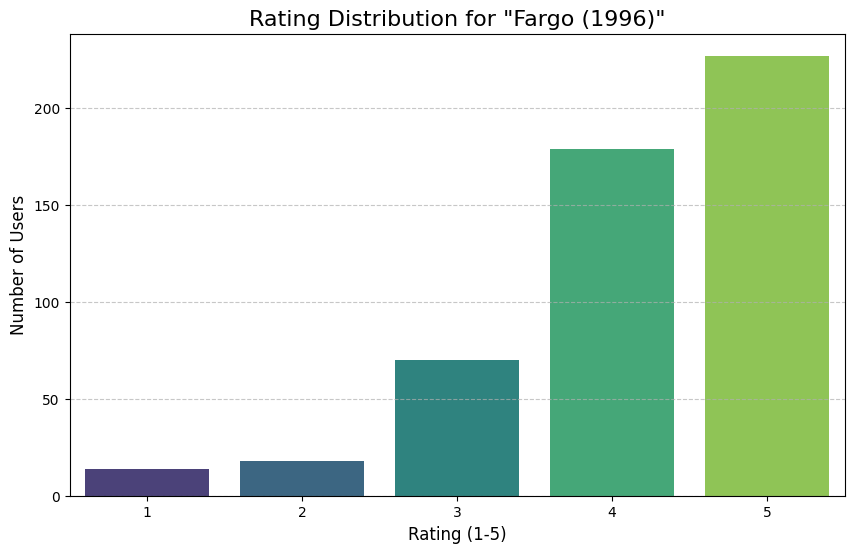

In [12]:
def plot_rating_distribution(movie_title):
    """
    Visualizes the rating distribution for a given movie title.
    """
    # Find the movie_id from the title
    movie_id = None
    for m_id, title in movie_titles.items():
        if title == movie_title:
            movie_id = m_id
            break

    if movie_id is None:
        print(f"Movie '{movie_title}' not found.")
        return

    # Get all ratings for this movie
    movie_ratings = ratings[ratings['movie_id'] == movie_id]

    if movie_ratings.empty:
        print(f"No ratings found for '{movie_title}'.")
        return

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.countplot(data=movie_ratings, x='rating', palette='viridis')
    plt.title(f'Rating Distribution for "{movie_title}"', fontsize=16)
    plt.xlabel('Rating (1-5)', fontsize=12)
    plt.ylabel('Number of Users', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Get the title of the top recommended movie to visualize
if recommendations:
    top_movie_title = recommendations[0][0]
    plot_rating_distribution(top_movie_title)
else:
    print("No recommendations to visualize.")